# Part 1: Image Generation and Embedding Extraction

In this notebook, we will:
1. Load the pre-trained U-Net model from notebook `05_CLIP.ipynb`
2. Generate images of flowers using text prompts
3. Extract embeddings from the model's bottleneck (down2 layer) using PyTorch hooks

## Setup & Installation

First, let's install the necessary libraries and set up the environment for Google Colab.

In [ ]:
# Check if running in Google Colab
import sys
import os
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
    # Mount Google Drive to access data and save results
    from google.colab import drive
    drive.mount('/content/drive')

    # Set up project directory
    PROJECT_DIR = '/content/drive/MyDrive/ahocv/Lab_3'
    DATA_DIR = '/content/drive/MyDrive/ahocv/GenerativeAIWithDiffusionModels/data/cropped_flowers/'

    # Change to project directory so all files are saved in Google Drive
    os.makedirs(PROJECT_DIR, exist_ok=True)
    os.chdir(PROJECT_DIR)
    print(f"Working directory: {os.getcwd()}")

    # Check if utils folder exists
    if not os.path.exists('utils'):
        print("Please upload the 'utils' folder to your Google Drive at:", PROJECT_DIR)
else:
    print("Running locally")
    PROJECT_DIR = './'
    DATA_DIR = "../GenerativeAIWithDiffusionModels/data/cropped_flowers/"

🔗 Running in Google Colab!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Working directory: /content/drive/MyDrive/ahocv/Lab_3


In [ ]:
# Install required packages
%pip install fiftyone wandb open-clip-torch einops ftfy regex tqdm

# Install CLIP from OpenAI
%pip install git+https://github.com/openai/CLIP.git --force-reinstall --no-deps

# Colab-specific: ensure GPU runtime
import torch
if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected. Go to Runtime > Change runtime type > GPU for faster training")

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5prapzn5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5prapzn5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=ad32cace008dfd6ec5983ea7fe9dc405fa0a4c1b7354c6e84109e4df4d14d36d
  Stored in directory: /tmp/pip-ephem-wheel-cache-g1p_bt2p/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
  Attempting uninstall: clip
    Found existing installation: clip 1.0
    Uninstalling clip-1.0:
      Successfully uninstalled clip-1.0
✅ GPU available: Tesla T4


## 1.1 Import Libraries and Setup

## 1.0 Weights & Biases Setup

Initialize WandB for tracking training metrics, losses, and generated images.

In [ ]:
import wandb

# Login to WandB (will prompt for API key in Colab)
wandb.login()

print("WandB logged in successfully")

wandb: Currently logged in as: finnfrei (finnfreiheit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ WandB logged in successfully!


In [4]:
import os
import sys
import csv
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from textwrap import wrap

# Add utils path (handles both local and Colab)
if 'google.colab' in sys.modules:
    sys.path.append('/content/drive/MyDrive/ahocv/Lab_3/utils')
    sys.path.append('/content/drive/MyDrive/ahocv/Lab_3')
else:
    sys.path.append('./utils')

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

# Force reload CLIP (remove from cache if exists)
if 'clip' in sys.modules:
    del sys.modules['clip']
if 'clip.clip' in sys.modules:
    del sys.modules['clip.clip']

# CLIP
import clip

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CLIP module: {clip.__file__}")
print(f"CLIP has load: {hasattr(clip, 'load')}")

Using device: cuda
CLIP module: /usr/local/lib/python3.12/dist-packages/clip/__init__.py
CLIP has load: True


## 1.2 Load CLIP Model

We use the ViT-B/32 CLIP model which provides 512-dimensional embeddings.

In [5]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512
print(f"CLIP model loaded with {CLIP_FEATURES} features")

CLIP model loaded with 512 features


In [6]:
# Debug clip import
import clip as clip_module
print(f"clip module location: {clip_module.__file__}")
print(f"clip module dir: {dir(clip_module)}")

clip module location: /usr/local/lib/python3.12/dist-packages/clip/__init__.py
clip module dir: ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'available_models', 'clip', 'load', 'model', 'simple_tokenizer', 'tokenize']


## 1.3 Initialize U-Net Model

Initialize the U-Net model with the same architecture as in notebook 05.

In [7]:
# Model hyperparameters (same as notebook 05)
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

# Image parameters
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

# Initialize DDPM
ddpm = ddpm_utils.DDPM(B, device)

# Initialize U-Net model with CLIP embeddings
model = UNet_utils.UNet(
    T=T,
    img_ch=IMG_CH,
    img_size=IMG_SIZE,
    down_chs=(256, 256, 512),
    t_embed_dim=8,
    c_embed_dim=CLIP_FEATURES
).to(device)

print(f"U-Net model initialized with {sum(p.numel() for p in model.parameters())} parameters")

U-Net model initialized with 44900355 parameters


## 1.4 Prepare Dataset and Train Model

We need to prepare the CLIP dataset and train the model first (following the approach from notebook 05).

In [ ]:
# Data directory - handles both local and Colab environments
if 'google.colab' in sys.modules:
    DATA_DIR = '/content/drive/MyDrive/ahocv/GenerativeAIWithDiffusionModels/data/cropped_flowers/'
else:
    DATA_DIR = "../GenerativeAIWithDiffusionModels/data/cropped_flowers/"

print(f"Data directory: {DATA_DIR}")

# Image transformations
pre_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

random_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
])

📁 Data directory: /content/drive/MyDrive/ahocv/GenerativeAIWithDiffusionModels/data/cropped_flowers/


In [9]:
# Create CLIP embeddings CSV file
data_paths = glob.glob(DATA_DIR + '*/*.jpg', recursive=True)
print(f"Found {len(data_paths)} images")

csv_path = 'clip.csv'

with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for idx, path in enumerate(data_paths):
        img = Image.open(path)
        clip_img = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
        label = clip_model.encode_image(clip_img)[0].tolist()
        writer.writerow([path] + label)
        if idx % 100 == 0:
            print(f"Processed {idx}/{len(data_paths)} images")

print(f"CLIP embeddings saved to {csv_path}")

Found 1166 images
Processed 0/1166 images
Processed 100/1166 images
Processed 200/1166 images
Processed 300/1166 images
Processed 400/1166 images
Processed 500/1166 images
Processed 600/1166 images
Processed 700/1166 images
Processed 800/1166 images
Processed 900/1166 images
Processed 1000/1166 images
Processed 1100/1166 images
CLIP embeddings saved to clip.csv


In [10]:
# Dataset class
class MyDataset(Dataset):
    def __init__(self, csv_path, preprocessed_clip=True):
        self.imgs = []
        self.preprocessed_clip = preprocessed_clip
        if preprocessed_clip:
            self.labels = torch.empty(
                len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
            )

        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                img = Image.open(row[0])
                self.imgs.append(pre_transforms(img).to(device))
                if preprocessed_clip:
                    label = [float(x) for x in row[1:]]
                    self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        if self.preprocessed_clip:
            label = self.labels[idx]
        else:
            batch_img = img[None, :, :, :]
            encoded_imgs = clip_model.encode_image(clip_preprocess(batch_img))
            label = encoded_imgs.to(device).float()[0]
        return img, label

    def __len__(self):
        return len(self.imgs)

# Create dataset and dataloader
train_data = MyDataset(csv_path)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(f"Dataset loaded with {len(train_data)} samples")

Dataset loaded with 1166 samples


In [11]:
# Context mask function (for classifier-free guidance)
def get_context_mask(c, drop_prob):
    c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
    return c_mask

In [12]:
# Training parameters
# NOTE: For full training, set epochs=100. Using 5 epochs for quick testing.
epochs = 100  # Change to 100 for full training
c_drop_prob = 0.1
lrate = 1e-4
save_dir = "generated_images/"

# Create save directory
os.makedirs(save_dir, exist_ok=True)

# Test prompts for visualization during training
test_text_list = [
    "A daisy",
    "A sunflower",
    "A rose"
]

# WandB configuration - all hyperparameters in one place
wandb_config = {
    # Model architecture
    "model_type": "U-Net",
    "T": T,
    "img_channels": IMG_CH,
    "img_size": IMG_SIZE,
    "down_channels": "(256, 256, 512)",
    "t_embed_dim": 8,
    "c_embed_dim": CLIP_FEATURES,

    # DDPM parameters
    "B_start": B_start,
    "B_end": B_end,

    # Training parameters
    "epochs": epochs,
    "learning_rate": lrate,
    "batch_size": BATCH_SIZE,
    "c_drop_prob": c_drop_prob,

    # CLIP model
    "clip_model": "ViT-B/32",
    "clip_features": CLIP_FEATURES,

    # Dataset
    "dataset": "cropped_flowers",
    "num_samples": len(train_data) if 'train_data' in dir() else "TBD",
}

print("Training Configuration:")
for key, value in wandb_config.items():
    print(f"  {key}: {value}")

Training Configuration:
  model_type: U-Net
  T: 400
  img_channels: 3
  img_size: 32
  down_channels: (256, 256, 512)
  t_embed_dim: 8
  c_embed_dim: 512
  B_start: 0.0001
  B_end: 0.02
  epochs: 100
  learning_rate: 0.0001
  batch_size: 128
  c_drop_prob: 0.1
  clip_model: ViT-B/32
  clip_features: 512
  dataset: cropped_flowers
  num_samples: 1166


In [13]:
# Sample function (from notebook 05)
def sample_flowers(text_list, return_store=True):
    """Generate flower images from text prompts."""
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    if return_store:
        return x_gen, x_gen_store
    return x_gen

In [14]:
# Skip model compilation due to path issues with spaces
# The model will work fine without compilation, just slightly slower
model_compiled = model  # Use non-compiled model
print("Using non-compiled model (torch.compile skipped due to path issues)")

Using non-compiled model (torch.compile skipped due to path issues)


In [ ]:
# Initialize WandB run for training
run = wandb.init(
    project="denoising_probabilistic_diffusion_models",
    name=f"unet_clip_ep{epochs}",
    config=wandb_config,
    tags=["training", "diffusion", "flowers", "clip-guided"],
    reinit=True  # Allow reinitializing in notebooks
)

print(f"WandB Run initialized: {run.name}")
print(f"View at: {run.url}")

# Training loop with WandB logging
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

# Track best loss
best_loss = float('inf')
epoch_losses = []

model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    num_batches = 0

    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x, c = batch
        c_mask = get_context_mask(c, c_drop_prob)
        loss = ddpm.get_loss(model_compiled, x, t, c, c_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        # Log batch-level metrics every 10 steps
        if step % 10 == 0:
            wandb.log({
                "batch_loss": loss.item(),
                "epoch": epoch,
                "step": step,
                "global_step": epoch * len(dataloader) + step
            })

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / num_batches
    epoch_losses.append(avg_epoch_loss)

    # Track best model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss

    # Log epoch-level metrics
    wandb.log({
        "epoch_loss": avg_epoch_loss,
        "best_loss": best_loss,
        "epoch": epoch,
        "learning_rate": lrate
    })

    print(f"Epoch {epoch} | Step {step:03d} | Avg Loss: {avg_epoch_loss:.4f} | Best: {best_loss:.4f}")

    # Save sample images periodically and log to WandB
    if epoch % 10 == 0 or epoch == int(epochs - 1):
        model.eval()
        x_gen, x_gen_store = sample_flowers(test_text_list)
        grid = make_grid(x_gen.cpu(), nrow=len(test_text_list))

        # Save locally
        img_path = save_dir + f"image_ep{epoch:02}.png"
        save_image(grid, img_path)
        print(f"  Saved images to {img_path}")

        # Log generated images to WandB
        wandb_images = []
        for i, (img, prompt) in enumerate(zip(x_gen.cpu(), test_text_list)):
            # Convert tensor to PIL Image
            img_np = ((img.permute(1, 2, 0).numpy() + 1) / 2 * 255).astype(np.uint8)
            wandb_images.append(wandb.Image(img_np, caption=prompt))

        wandb.log({
            "generated_samples": wandb_images,
            "sample_grid": wandb.Image(img_path, caption=f"Epoch {epoch}"),
            "epoch": epoch
        })

        model.train()

# Log training summary
wandb.summary.update({
    "final_loss": epoch_losses[-1],
    "best_loss": best_loss,
    "total_epochs": epochs,
    "total_batches": epochs * len(dataloader)
})

print(f"\nTraining complete. Final loss: {epoch_losses[-1]:.4f}")

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


🚀 WandB Run initialized: unet_clip_ep100
📊 View at: https://wandb.ai/finnfreiheit/denoising_probabilistic_diffusion_models/runs/vmyzkk2l
Epoch 0 | Step 008 | Avg Loss: 0.9416 | Best: 0.9416
  Saved images to generated_images/image_ep00.png
Epoch 1 | Step 008 | Avg Loss: 0.3798 | Best: 0.3798
Epoch 2 | Step 008 | Avg Loss: 0.2236 | Best: 0.2236
Epoch 3 | Step 008 | Avg Loss: 0.1989 | Best: 0.1989
Epoch 4 | Step 008 | Avg Loss: 0.1893 | Best: 0.1893
Epoch 5 | Step 008 | Avg Loss: 0.1756 | Best: 0.1756
Epoch 6 | Step 008 | Avg Loss: 0.1713 | Best: 0.1713
Epoch 7 | Step 008 | Avg Loss: 0.1549 | Best: 0.1549
Epoch 8 | Step 008 | Avg Loss: 0.1592 | Best: 0.1549
Epoch 9 | Step 008 | Avg Loss: 0.1479 | Best: 0.1479
Epoch 10 | Step 008 | Avg Loss: 0.1488 | Best: 0.1479
  Saved images to generated_images/image_ep10.png
Epoch 11 | Step 008 | Avg Loss: 0.1459 | Best: 0.1459
Epoch 12 | Step 008 | Avg Loss: 0.1420 | Best: 0.1420
Epoch 13 | Step 008 | Avg Loss: 0.1343 | Best: 0.1343
Epoch 14 | Step 0

In [ ]:
# Save trained model locally
model_path = 'unet_flowers_clip.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Log model as WandB artifact
model_artifact = wandb.Artifact(
    name="unet_flowers_clip",
    type="model",
    description="U-Net model trained on flowers with CLIP conditioning",
    metadata=wandb_config
)
model_artifact.add_file(model_path)
wandb.log_artifact(model_artifact)
print(f"Model artifact logged to WandB")

💾 Model saved to unet_flowers_clip.pth
📦 Model artifact logged to WandB


## 1.5 Embedding Extraction using Hooks

We will use PyTorch hooks to extract the output of the 'down2' layer (the bottleneck).

In [17]:
# Storage for extracted embeddings
embeddings_storage = {}

def get_embedding_hook(name):
    """Create a hook function to capture layer outputs."""
    def hook(model, input, output):
        embeddings_storage[name] = output.detach()
    return hook

# Register a forward hook on the down2 layer of the U-Net model
hook_handle = model.down2.register_forward_hook(get_embedding_hook('down2'))
print("Hook registered on 'down2' layer")

Hook registered on 'down2' layer


In [18]:
# Define text prompts for image generation
text_prompts = [
    "A photo of a red rose",
    "A photo of a white daisy",
    "A photo of a yellow sunflower",
    "A beautiful pink rose with green leaves",
    "A bright orange sunflower in sunlight",
    "A white daisy with yellow center",
    "A red rose bud",
    "A field of sunflowers",
    "A bouquet of daisies",
    "A single red rose on a stem"
]

print(f"Defined {len(text_prompts)} text prompts for generation")

Defined 10 text prompts for generation


In [19]:
# Modified sample function that stores embeddings during generation
@torch.no_grad()
def sample_flowers_with_embeddings(text_list, w_tests=None, store_freq=10):
    """
    Generate flower images from text prompts and extract embeddings.

    Returns:
        x_gen: Generated images
        all_embeddings: List of embeddings from down2 layer for each final image
    """
    if w_tests is None:
        w_tests = [1.0]  # Use single guidance weight for simplicity

    # Tokenize text prompts
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()

    n_samples = len(w_tests) * len(c)

    # One w for each c
    w = torch.tensor(w_tests).float().repeat_interleave(len(c))
    w = w[:, None, None, None].to(device)
    x_t = torch.randn(n_samples, *INPUT_SIZE).to(device)

    # One c for each w
    c = c.repeat(len(w_tests), 1)

    # Double the batch for classifier-free guidance
    c = c.repeat(2, 1)

    # Don't drop context at test time
    c_mask = torch.ones_like(c).to(device)
    c_mask[n_samples:] = 0.0

    # Clear previous embeddings
    embeddings_storage.clear()

    # Store embeddings from the final timestep
    final_embeddings = []

    for i in range(0, T)[::-1]:
        # Duplicate t for each sample
        t = torch.tensor([i]).to(device)
        t = t.repeat(n_samples, 1, 1, 1)

        # Double the batch
        x_t = x_t.repeat(2, 1, 1, 1)
        t = t.repeat(2, 1, 1, 1)

        # Forward pass (hooks will capture embeddings)
        e_t = model(x_t, t, c, c_mask)

        # Store embeddings at the final timestep (t=0)
        if i == 0:
            # Extract embeddings from the first n_samples (with context)
            final_embeddings = embeddings_storage['down2'][:n_samples].clone()

        e_t_keep_c = e_t[:n_samples]
        e_t_drop_c = e_t[n_samples:]
        e_t = (1 + w) * e_t_keep_c - w * e_t_drop_c

        # Deduplicate batch for reverse diffusion
        x_t = x_t[:n_samples]
        t = t[:n_samples]
        x_t = ddpm.reverse_q(x_t, t, e_t)

    return x_t, final_embeddings

print("Sample function with embedding extraction defined")

Sample function with embedding extraction defined


In [20]:
# Set model to evaluation mode
model.eval()

# Generate images and extract embeddings
print("Generating images and extracting embeddings...")
generated_images, extracted_embeddings = sample_flowers_with_embeddings(text_prompts)

print(f"Generated {generated_images.shape[0]} images")
print(f"Extracted embeddings shape: {extracted_embeddings.shape}")

Generating images and extracting embeddings...
Generated 10 images
Extracted embeddings shape: torch.Size([10, 512, 8, 8])


In [21]:
# Save generated images
os.makedirs("generated_images/final", exist_ok=True)

# Save individual images
saved_image_paths = []
for idx, (img, prompt) in enumerate(zip(generated_images, text_prompts)):
    img_path = f"generated_images/final/image_{idx:02d}.png"
    save_image(img, img_path)
    saved_image_paths.append(img_path)
    print(f"Saved: {img_path} - '{prompt}'")

# Save grid of all images
grid = make_grid(generated_images.cpu(), nrow=5)
save_image(grid, "generated_images/final/all_generated.png")
print("\nSaved grid to generated_images/final/all_generated.png")

Saved: generated_images/final/image_00.png - 'A photo of a red rose'
Saved: generated_images/final/image_01.png - 'A photo of a white daisy'
Saved: generated_images/final/image_02.png - 'A photo of a yellow sunflower'
Saved: generated_images/final/image_03.png - 'A beautiful pink rose with green leaves'
Saved: generated_images/final/image_04.png - 'A bright orange sunflower in sunlight'
Saved: generated_images/final/image_05.png - 'A white daisy with yellow center'
Saved: generated_images/final/image_06.png - 'A red rose bud'
Saved: generated_images/final/image_07.png - 'A field of sunflowers'
Saved: generated_images/final/image_08.png - 'A bouquet of daisies'
Saved: generated_images/final/image_09.png - 'A single red rose on a stem'

Saved grid to generated_images/final/all_generated.png


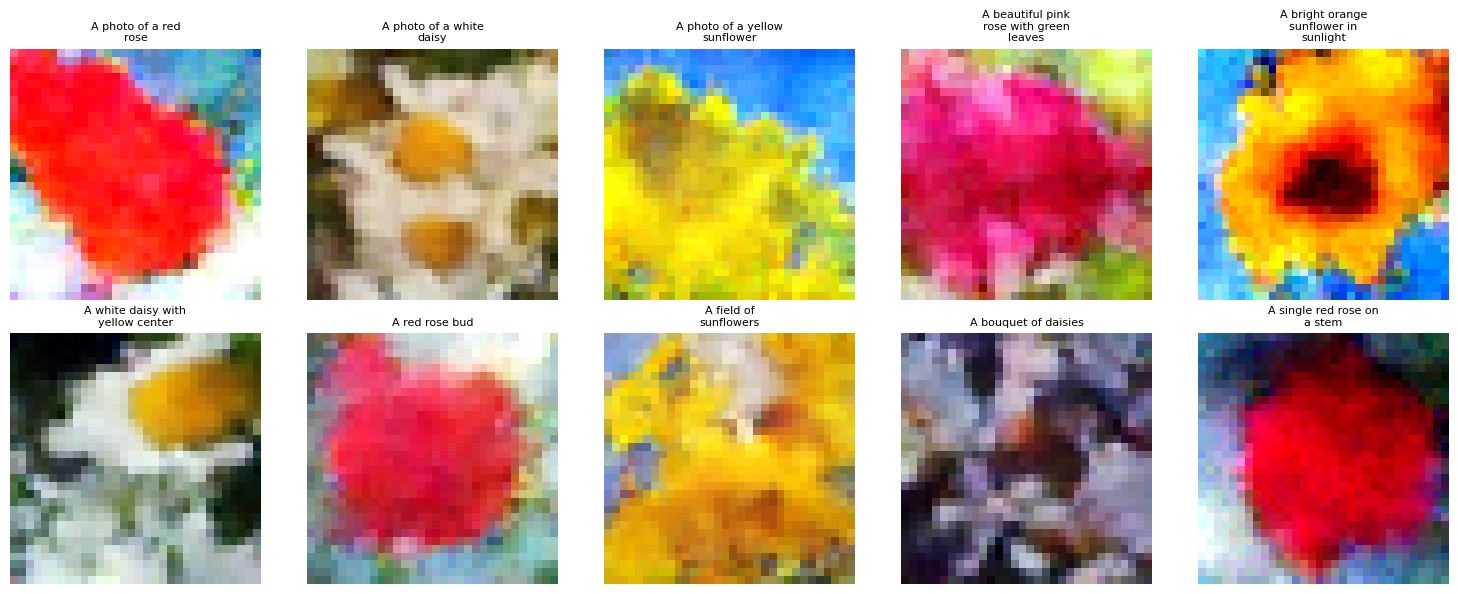

In [22]:
# Visualize generated images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, (img, prompt) in enumerate(zip(generated_images, text_prompts)):
    ax = axes[idx]
    # Convert from [-1, 1] to [0, 1]
    img_display = (img.cpu().permute(1, 2, 0).numpy() + 1) / 2
    img_display = np.clip(img_display, 0, 1)
    ax.imshow(img_display)
    ax.set_title('\n'.join(wrap(prompt, 20)), fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.savefig("generated_images/final/visualization.png", dpi=150)
plt.show()

In [23]:
# Flatten embeddings for analysis (from [N, C, H, W] to [N, C*H*W])
flat_embeddings = extracted_embeddings.view(extracted_embeddings.shape[0], -1)
print(f"Flattened embeddings shape: {flat_embeddings.shape}")

# Save embeddings for later use (Part 2 and Part 3)
embeddings_data = {
    'embeddings': flat_embeddings.cpu().numpy(),
    'raw_embeddings': extracted_embeddings.cpu().numpy(),
    'prompts': text_prompts,
    'image_paths': saved_image_paths
}

np.save('embeddings_data.npy', embeddings_data)
print("Embeddings saved to embeddings_data.npy")

Flattened embeddings shape: torch.Size([10, 32768])
Embeddings saved to embeddings_data.npy


In [24]:
# Cleanup: Remove the hook
hook_handle.remove()
print("Hook removed")

Hook removed


## 1.6 Summary

In this part, we have:
1. Set up environment for Google Colab compatibility
2. Initialized WandB for training metrics logging
3. Loaded the CLIP model for text encoding
4. Initialized and trained the U-Net model with full metrics tracking
5. Logged training metrics to WandB (loss, learning rate, generated samples)
6. Registered a forward hook on the `down2` layer for embedding extraction
7. Generated images from text prompts using classifier-free guidance
8. Extracted intermediate embeddings from the bottleneck layer
9. Saved generated images and embeddings for use in Parts 2, 3, and 4
10. Saved model artifact to WandB for versioning

In [ ]:
# Display final summary
print("="*60)
print("PART 1 SUMMARY")
print("="*60)
print(f"Number of generated images: {len(text_prompts)}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Embedding dimensions: {flat_embeddings.shape[1]}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nFiles saved:")
print(f"  - Generated images: generated_images/final/")
print(f"  - Embeddings: embeddings_data.npy")
print(f"  - Model: {model_path}")
print(f"\nWandB Logging:")
print(f"  - Project: diffusion-flowers-training")
print(f"  - Tracked: batch_loss, epoch_loss, learning_rate")
print(f"  - Logged: generated samples at each checkpoint")
print(f"  - Artifact: model weights saved to WandB")
print("="*60)

PART 1 SUMMARY
Number of generated images: 10
Image size: 32x32
Embedding dimensions: 32768
Model parameters: 44900355

📁 Files saved:
  - Generated images: generated_images/final/
  - Embeddings: embeddings_data.npy
  - Model: unet_flowers_clip.pth

📊 WandB Logging:
  - Project: diffusion-flowers-training
  - Tracked: batch_loss, epoch_loss, learning_rate
  - Logged: generated samples at each checkpoint
  - Artifact: model weights saved to WandB


In [ ]:
# Finish WandB run
wandb.finish()
print("WandB run finished successfully")
print(f"View your training results in the WandB dashboard")

batch_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.08514
best_loss,0.07268
epoch,99
epoch_loss,0.08571


✅ WandB run finished successfully!
📊 View your training results in the WandB dashboard
